In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

import sys
print('Python version:', sys.version)


Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [3]:

# Robust data-loading helper
import os
import pandas as pd
from pathlib import Path

def safe_read_csv(path, parse_dates=None, dtype=None, **kwargs):
    """Read CSV with graceful error messages."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {path}. Please place it in the working directory or update the path.")
    try:
        df = pd.read_csv(p, parse_dates=parse_dates, dtype=dtype, low_memory=False, **kwargs)
    except Exception as e:
        raise RuntimeError(f"Failed to read {path}: {e}")
    return df

def normalize_columns(df):
    # strip whitespace, lower-case, replace spaces and hyphens with underscore
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
    return df



In [4]:

# Feature engineering utilities (per-trade and per-trader)
import numpy as np

def prepare_trade_features(df):
    df = df.copy()
    # Ensure expected columns exist
    # Common column name mappings (update if your notebook uses different names)
    col_map = {
        'time': 'time',
        'execution_price': 'execution_price',
        'price': 'execution_price',
        'size': 'size',
        'closedpnl': 'closedpnl',
        'leverage': 'leverage',
        'account': 'account',
        'side': 'side'
    }
    # lower-case column names for mapping
    df.columns = [c.lower() for c in df.columns]
    # convert numerics
    for c in ['closedpnl','size','execution_price','leverage']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # datetime handling
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['trade_date'] = df['time'].dt.date
        df['hour_of_day'] = df['time'].dt.hour
        df['day_of_week'] = df['time'].dt.day_name()
    # notional and return
    if all(x in df.columns for x in ['size','execution_price']):
        df['notional'] = (df['size'] * df['execution_price']).abs()
    else:
        df['notional'] = np.nan
    if 'closedpnl' in df.columns:
        df['return'] = df['closedpnl'] / df['notional'].replace({0: np.nan})
        df['win'] = (df['closedpnl'] > 0).astype(int)
    return df

def aggregate_trader_stats(df):
    # df expected to contain 'account', 'closedpnl', 'return', 'win', 'leverage', 'notional'
    g = df.groupby('account').agg(
        total_pnl = ('closedpnl','sum'),
        avg_return = ('return','mean'),
        win_rate = ('win','mean'),
        avg_leverage = ('leverage','mean'),
        trade_count = ('account','size')
    ).reset_index()
    return g


In [5]:
import pandas as pd

# Load the Historical Trader Data into a pandas DataFrame
trader_df = pd.read_csv(r'C:\Users\kolli\Downloads\historical_data.csv')

# Load the Fear Greed Index data into a pandas DataFrame
sentiment_df = pd.read_csv(r'C:\Users\kolli\Downloads\fear_greed_index.csv')

# Display the first few rows of each DataFrame to verify loading
print("Historical Trader Data:")
display(trader_df.head())

print("\nFear Greed Index Data:")
display(sentiment_df.head())

Historical Trader Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



Fear Greed Index Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## Data preprocessing

Convert relevant columns to datetime format and handle any missing values or inconsistencies in both dataframes.


**Reasoning**:
Convert the timestamp columns to datetime objects and handle missing values in both dataframes.



In [6]:
# Convert 'Timestamp IST' in trader_df to datetime objects
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Convert 'date' in sentiment_df to datetime objects
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Check for missing values in trader_df
print("Missing values in trader_df before handling:")
display(trader_df.isnull().sum())

# Check for missing values in sentiment_df
print("\nMissing values in sentiment_df before handling:")
display(sentiment_df.isnull().sum())

# Handle missing values (dropping rows with missing values in this case)
trader_df.dropna(inplace=True)
sentiment_df.dropna(inplace=True)

# Verify that missing values have been handled
print("\nMissing values in trader_df after handling:")
display(trader_df.isnull().sum())

print("\nMissing values in sentiment_df after handling:")
display(sentiment_df.isnull().sum())

Missing values in trader_df before handling:


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Missing values in sentiment_df before handling:


timestamp         0
value             0
classification    0
date              0
dtype: int64


Missing values in trader_df after handling:


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Missing values in sentiment_df after handling:


timestamp         0
value             0
classification    0
date              0
dtype: int64

## Feature engineering

Create new features in the `trader_df` such as trade duration, profit/loss percentage, and volatility.


**Reasoning**:
Calculate trade duration, profit/loss percentage, and volatility for each trade and add them as new columns to the trader_df.



In [7]:
# Sort the dataframe by Account, Coin, and Timestamp IST to ensure correct calculation of consecutive trades
trader_df.sort_values(by=['Account', 'Coin', 'Timestamp IST'], inplace=True)

# Calculate trade duration: time difference between consecutive trades for each account and coin
trader_df['Trade Duration'] = trader_df.groupby(['Account', 'Coin'])['Timestamp IST'].diff().dt.total_seconds().fillna(0)

# Calculate profit/loss percentage: handle potential division by zero
trader_df['PnL Percentage'] = (trader_df['Closed PnL'] / trader_df['Size USD']).fillna(0)

# Calculate volatility: absolute percentage change in Execution Price between consecutive trades
trader_df['Volatility'] = trader_df.groupby(['Account', 'Coin'])['Execution Price'].pct_change().abs().fillna(0)

# Display the first few rows with the new features
display(trader_df.head())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Trade Duration,PnL Percentage,Volatility
14229,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,0.7145,2293.26,SELL,2024-11-11 08:28:00,0.0000,Open Short,0.0,0x0400fa3d545a442059fc0416807bdc02014d001a2a37...,45991568323,True,0.802640,5.260000e+14,1.730000e+12,0.0,0.0,0.0
14230,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,2.0000,6419.20,SELL,2024-11-11 08:28:00,-0.7145,Open Short,0.0,0x0400fa3d545a442059fc0416807bdc02014d001a2a37...,45991568323,True,2.246720,5.780000e+14,1.730000e+12,0.0,0.0,0.0
14231,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,4.6273,14851.78,SELL,2024-11-11 08:28:00,-2.7145,Open Short,0.0,0x0400fa3d545a442059fc0416807bdc02014d001a2a37...,45991568323,True,5.198123,5.490000e+14,1.730000e+12,0.0,0.0,0.0
14232,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,2.5000,8024.00,SELL,2024-11-11 08:28:00,-7.3418,Open Short,0.0,0x0400fa3d545a442059fc0416807bdc02014d001a2a37...,45991568323,True,2.808400,3.170000e+14,1.730000e+12,0.0,0.0,0.0
14233,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,9.3471,30000.45,SELL,2024-11-11 08:28:00,-9.8418,Open Short,0.0,0x0400fa3d545a442059fc0416807bdc02014d001a2a37...,45991568323,True,10.500158,5.450000e+14,1.730000e+12,0.0,0.0,0.0


## Merge dataframes


Merge `trader_df` and `sentiment_df` based on the timestamp or date column to align trader activity with market sentiment.


**Reasoning**:
Convert the 'Timestamp IST' column in trader_df to a date format and then merge the two dataframes on the date column, handling potential naming conflicts. Finally, display the head and shape of the merged dataframe.



In [8]:
# Convert 'Timestamp IST' in trader_df to date only for merging
trader_df['Trade_Date'] = trader_df['Timestamp IST'].dt.date

# Convert 'date' in sentiment_df to datetime objects and then to date only for merging
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Merge the dataframes
merged_df = pd.merge(trader_df, sentiment_df, left_on='Trade_Date', right_on='date', how='left', suffixes=('_trader', '_sentiment'))

# Display the first few rows of the merged DataFrame
print("Merged DataFrame head:")
display(merged_df.head())

# Check the shape of the merged DataFrame
print("\nMerged DataFrame shape:")
print(merged_df.shape)

Merged DataFrame head:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Trade ID,Timestamp,Trade Duration,PnL Percentage,Volatility,Trade_Date,timestamp,value,classification,date
0,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,0.7145,2293.26,SELL,2024-11-11 08:28:00,0.0000,Open Short,0.0,...,5.260000e+14,1.730000e+12,0.0,0.0,0.0,2024-11-11,1.731303e+09,76.0,Extreme Greed,2024-11-11
1,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,2.0000,6419.20,SELL,2024-11-11 08:28:00,-0.7145,Open Short,0.0,...,5.780000e+14,1.730000e+12,0.0,0.0,0.0,2024-11-11,1.731303e+09,76.0,Extreme Greed,2024-11-11
2,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,4.6273,14851.78,SELL,2024-11-11 08:28:00,-2.7145,Open Short,0.0,...,5.490000e+14,1.730000e+12,0.0,0.0,0.0,2024-11-11,1.731303e+09,76.0,Extreme Greed,2024-11-11
3,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,2.5000,8024.00,SELL,2024-11-11 08:28:00,-7.3418,Open Short,0.0,...,3.170000e+14,1.730000e+12,0.0,0.0,0.0,2024-11-11,1.731303e+09,76.0,Extreme Greed,2024-11-11
4,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,3209.6,9.3471,30000.45,SELL,2024-11-11 08:28:00,-9.8418,Open Short,0.0,...,5.450000e+14,1.730000e+12,0.0,0.0,0.0,2024-11-11,1.731303e+09,76.0,Extreme Greed,2024-11-11



Merged DataFrame shape:
(211224, 24)


## Exploratory data analysis (eda)

Analyze the distributions of key variables, identify correlations between trader performance metrics and sentiment scores, and visualize patterns.


**Reasoning**:

Analyze the distribution of the 'value' column in `merged_df` using descriptive statistics and a histogram to understand the distribution of sentiment scores. Calculate the correlation matrix for numerical columns in `merged_df`, focusing on relationships between trader performance metrics and sentiment scores. Create scatter plots to visualize the relationships between 'value' and key trader performance metrics. Analyze the distributions of 'Closed PnL' and 'PnL Percentage' using descriptive statistics and histograms, considering potential differences based on sentiment classification.



Descriptive statistics for Sentiment Value:


count    211218.000000
mean         51.649656
std          21.012784
min          10.000000
25%          33.000000
50%          49.000000
75%          72.000000
max          94.000000
Name: value, dtype: float64

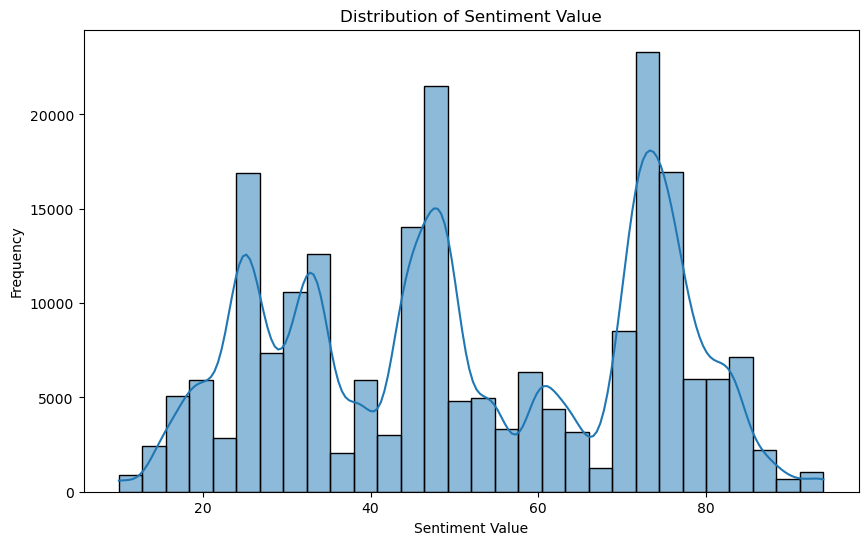


Correlation Matrix:


,Execution Price,Size Tokens,Size USD,Closed PnL,Fee,Trade Duration,PnL Percentage,Volatility,value
Execution Price,1.000000,-0.017185,0.189855,-0.006505,0.225265,-0.009703,-0.007969,-0.029185,-0.027558
Size Tokens,-0.017185,1.000000,0.013310,0.005068,0.006710,0.018661,-0.000265,0.036618,0.023080
Size USD,0.189855,0.013310,1.000000,0.123589,0.745939,0.000653,-0.001886,-0.003267,-0.029843
Closed PnL,-0.006505,0.005068,0.123589,1.000000,0.084020,0.003353,0.039508,0.002284,0.008121
Fee,0.225265,0.006710,0.745939,0.084020,1.000000,-0.000811,-0.002338,-0.007033,-0.026877
Trade Duration,-0.009703,0.018661,0.000653,0.003353,-0.000811,1.000000,0.000324,0.347052,0.007975
PnL Percentage,-0.007969,-0.000265,-0.001886,0.039508,-0.002338,0.000324,1.000000,0.002151,0.012875
Volatility,-0.029185,0.036618,-0.003267,0.002284,-0.007033,0.347052,0.002151,1.000000,0.041063
value,-0.027558,0.023080,-0.029843,0.008121,-0.026877,0.007975,0.012875,0.041063,1.000000



Correlation with Sentiment Value:


value              1.000000
Volatility         0.041063
Size Tokens        0.023080
PnL Percentage     0.012875
Closed PnL         0.008121
Trade Duration     0.007975
Fee               -0.026877
Execution Price   -0.027558
Size USD          -0.029843
Name: value, dtype: float64

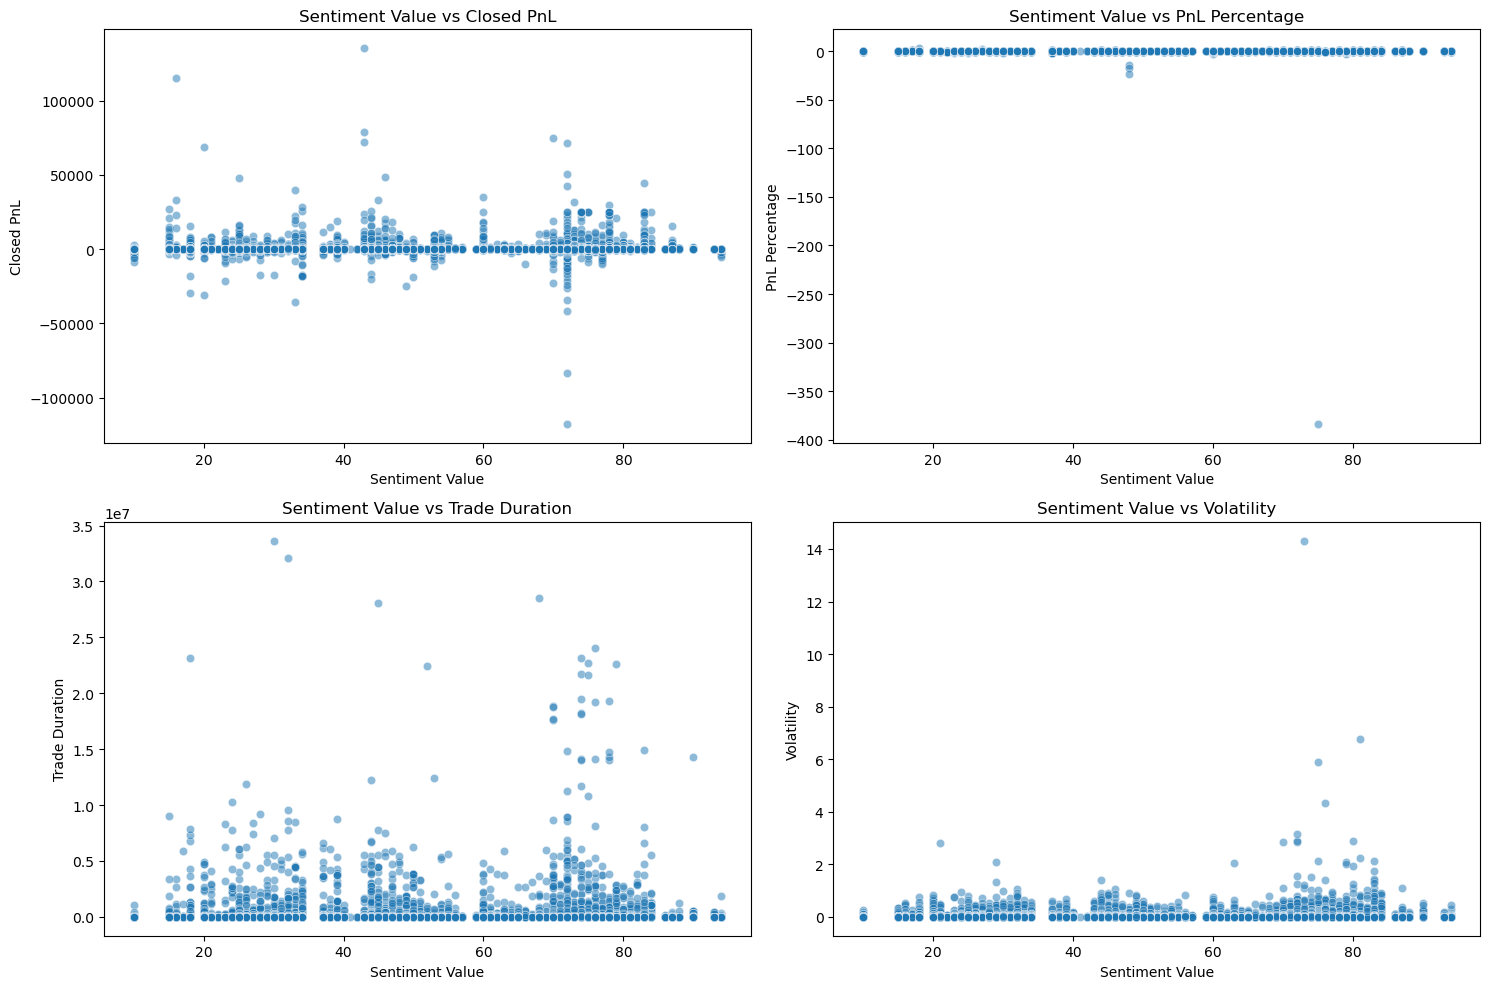


Descriptive statistics for Closed PnL by Sentiment Classification:


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,21400.0,34.537862,1136.056091,-31036.69194,0.0,0.0,5.635032,115287.00000
Extreme Greed,39992.0,67.892861,766.828294,-10259.46800,0.0,0.0,10.028709,44223.45187
Fear,61837.0,54.290400,935.355438,-35681.74723,0.0,0.0,5.590856,135329.09010
Greed,50303.0,42.743559,1116.028390,-117990.10410,0.0,0.0,4.944105,74530.52371
Neutral,37686.0,34.307718,517.122220,-24500.00000,0.0,0.0,3.995795,48504.09555



Descriptive statistics for PnL Percentage by Sentiment Classification:


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,21400.0,0.004321,0.095705,-1.435997,0.0,0.0,0.008771,3.403550
Extreme Greed,39992.0,0.040015,1.929376,-384.406426,0.0,0.0,0.029008,1.000357
Fear,61837.0,0.015409,0.072819,-1.361753,0.0,0.0,0.007346,2.604130
Greed,50303.0,0.019646,0.099614,-3.100918,0.0,0.0,0.010610,1.487955
Neutral,37686.0,0.009936,0.175546,-23.359398,0.0,0.0,0.007872,1.366625


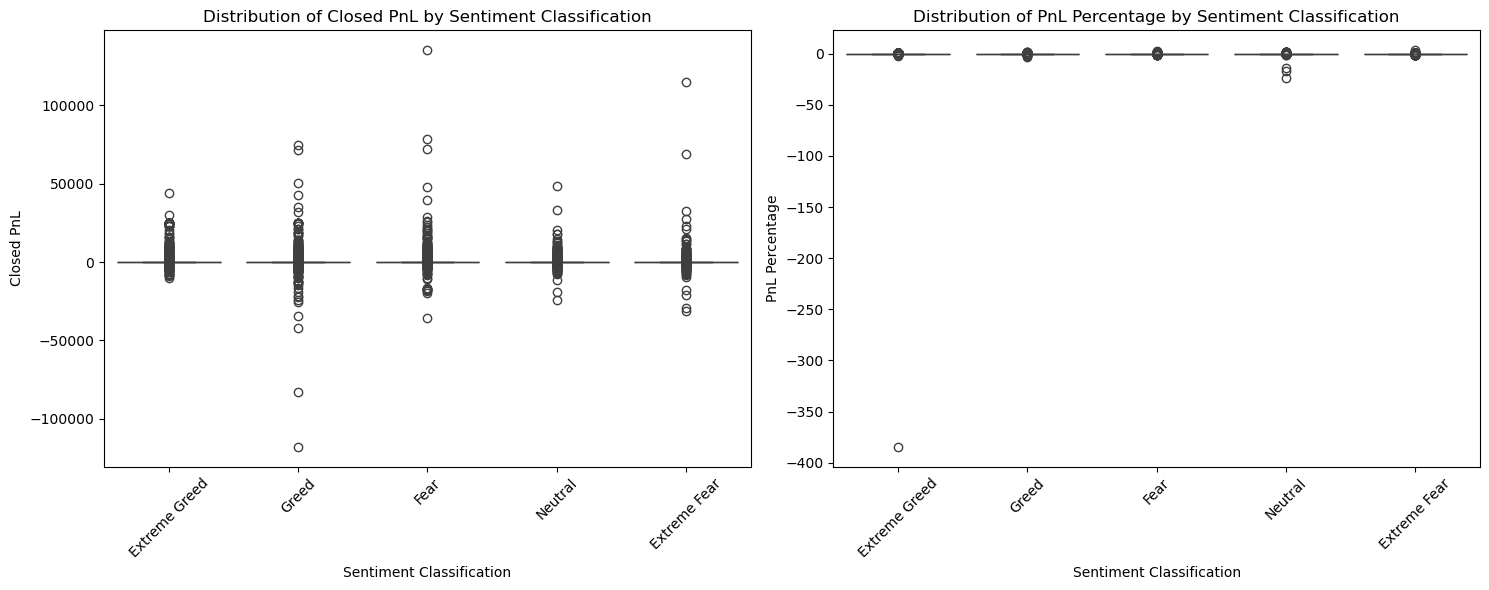

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analyze the distribution of the 'value' column
print("Descriptive statistics for Sentiment Value:")
display(merged_df['value'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['value'].dropna(), kde=True, bins=30)
plt.title('Distribution of Sentiment Value')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.show()

# 2. Calculate the correlation matrix
numerical_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee', 'Trade Duration', 'PnL Percentage', 'Volatility', 'value']
correlation_matrix = merged_df[numerical_cols].corr()

print("\nCorrelation Matrix:")
display(correlation_matrix)

# Focus on correlations with 'value'
print("\nCorrelation with Sentiment Value:")
display(correlation_matrix['value'].sort_values(ascending=False))

# 3. Create scatter plots
performance_metrics = ['Closed PnL', 'PnL Percentage', 'Trade Duration', 'Volatility']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(performance_metrics):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=merged_df, x='value', y=metric, alpha=0.5)
    plt.title(f'Sentiment Value vs {metric}')
    plt.xlabel('Sentiment Value')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# 4. Analyze distributions of 'Closed PnL' and 'PnL Percentage' based on sentiment classification
print("\nDescriptive statistics for Closed PnL by Sentiment Classification:")
display(merged_df.groupby('classification')['Closed PnL'].describe())

print("\nDescriptive statistics for PnL Percentage by Sentiment Classification:")
display(merged_df.groupby('classification')['PnL Percentage'].describe())

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title('Distribution of Closed PnL by Sentiment Classification')
plt.xlabel('Sentiment Classification')
plt.ylabel('Closed PnL')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, x='classification', y='PnL Percentage')
plt.title('Distribution of PnL Percentage by Sentiment Classification')
plt.xlabel('Sentiment Classification')
plt.ylabel('PnL Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Sentiment analysis integration


Explore how different sentiment classifications (Fear/Greed) correlate with trader behavior and performance.


**Reasoning**:

Calculate the average and median performance metrics for each sentiment classification and then visualize these averages and medians using bar plots to compare them across different sentiment categories.



Average and Median Performance Metrics by Sentiment Classification:


,Avg_Closed_PnL,Median_Closed_PnL,Avg_PnL_Percentage,Median_PnL_Percentage,Avg_Trade_Duration,Median_Trade_Duration,Avg_Volatility,Median_Volatility
classification,,,,,,,,
Extreme Fear,34.537862,0.0,0.004321,0.0,12467.873832,0.0,0.003510,0.000000
Extreme Greed,67.892861,0.0,0.040015,0.0,17454.856971,0.0,0.009591,0.000075
Fear,54.290400,0.0,0.015409,0.0,13556.801915,0.0,0.003295,0.000000
Greed,42.743559,0.0,0.019646,0.0,18638.871240,0.0,0.006128,0.000019
Neutral,34.307718,0.0,0.009936,0.0,11748.348989,0.0,0.003412,0.000000


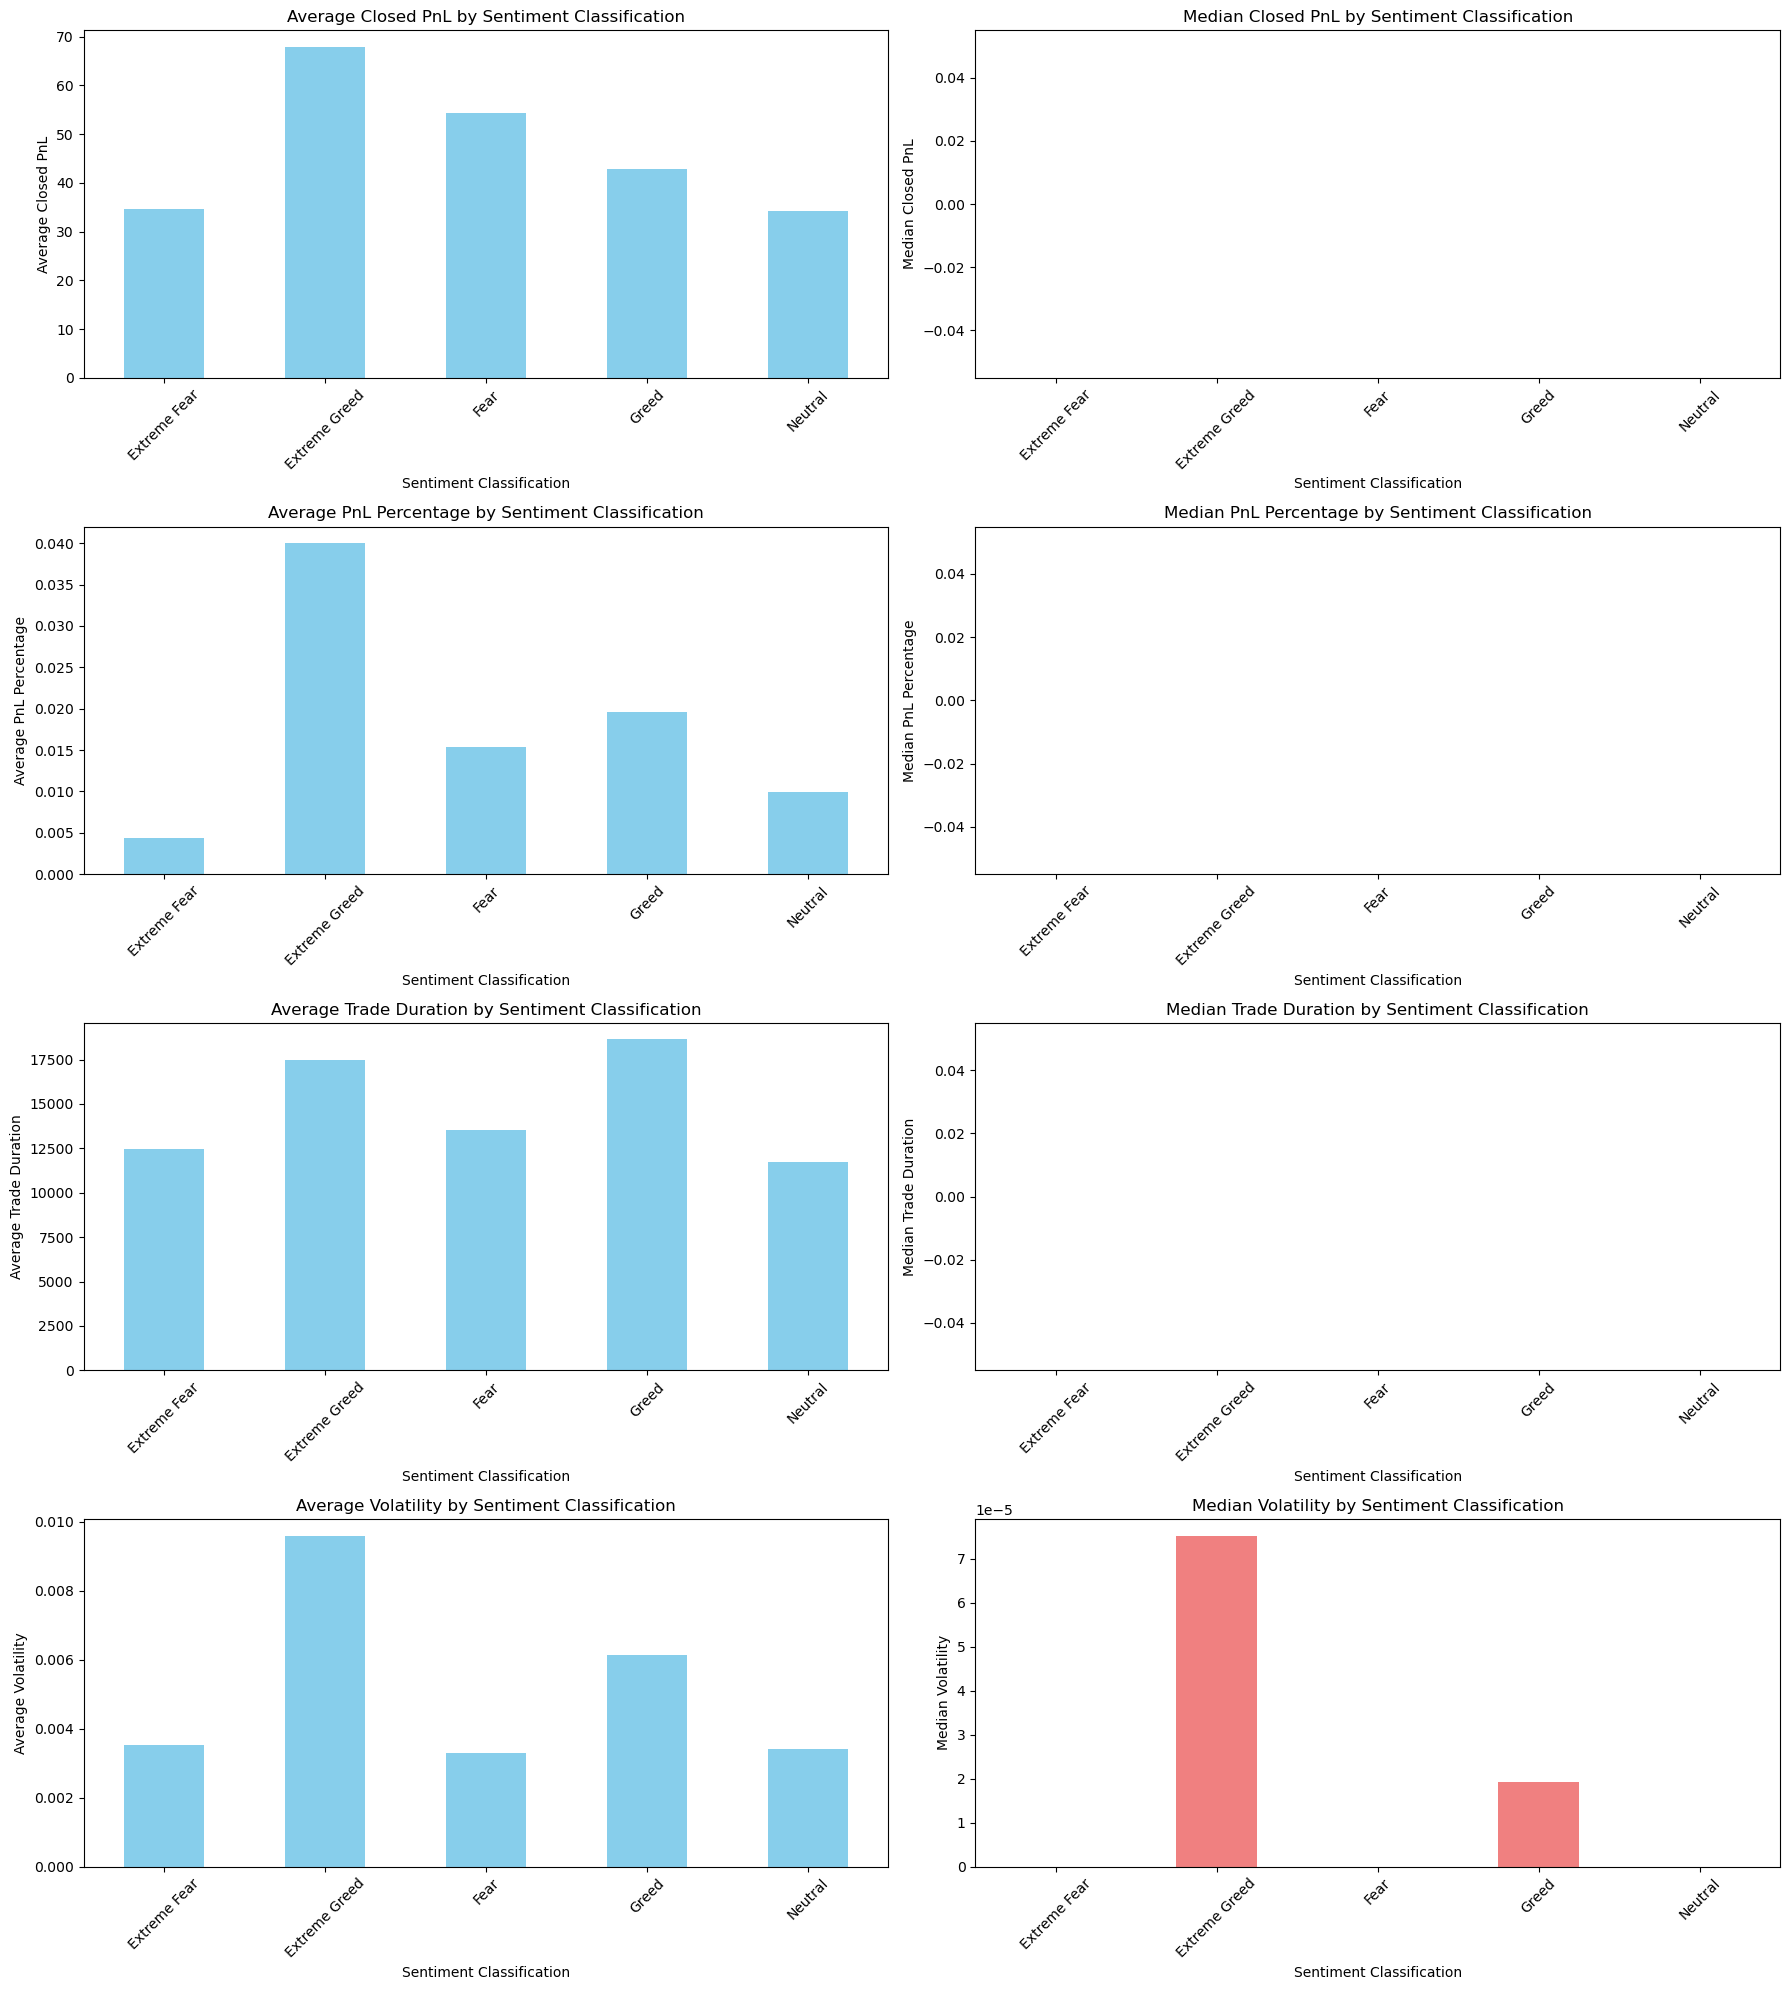

In [10]:
# Calculate average and median performance metrics for each sentiment classification
sentiment_performance = merged_df.groupby('classification').agg(
    Avg_Closed_PnL=('Closed PnL', 'mean'),
    Median_Closed_PnL=('Closed PnL', 'median'),
    Avg_PnL_Percentage=('PnL Percentage', 'mean'),
    Median_PnL_Percentage=('PnL Percentage', 'median'),
    Avg_Trade_Duration=('Trade Duration', 'mean'),
    Median_Trade_Duration=('Trade Duration', 'median'),
    Avg_Volatility=('Volatility', 'mean'),
    Median_Volatility=('Volatility', 'median')
)

print("Average and Median Performance Metrics by Sentiment Classification:")
display(sentiment_performance)

# Create bar plots to compare average and median performance metrics across sentiment classifications
performance_metrics = ['Closed PnL', 'PnL Percentage', 'Trade Duration', 'Volatility']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 20))
axes = axes.flatten()

for i, metric in enumerate(performance_metrics):
    # Average plot
    sentiment_performance[f'Avg_{metric.replace(" ", "_")}'].plot(kind='bar', ax=axes[i*2], color='skyblue')
    axes[i*2].set_title(f'Average {metric} by Sentiment Classification')
    axes[i*2].set_xlabel('Sentiment Classification')
    axes[i*2].set_ylabel(f'Average {metric}')
    axes[i*2].tick_params(axis='x', rotation=45)

    # Median plot
    sentiment_performance[f'Median_{metric.replace(" ", "_")}'].plot(kind='bar', ax=axes[i*2+1], color='lightcoral')
    axes[i*2+1].set_title(f'Median {metric} by Sentiment Classification')
    axes[i*2+1].set_xlabel('Sentiment Classification')
    axes[i*2+1].set_ylabel(f'Median {metric}')
    axes[i*2+1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Pattern recognition

Use statistical methods or machine learning techniques to identify hidden patterns and relationships in the combined dataset.


**Reasoning**:

Select relevant numerical features, standardize them, apply K-Means clustering, determine the optimal number of clusters using the elbow method, analyze cluster characteristics, and explore the distribution of sentiment classifications within clusters to identify hidden patterns and relationships in the combined dataset.



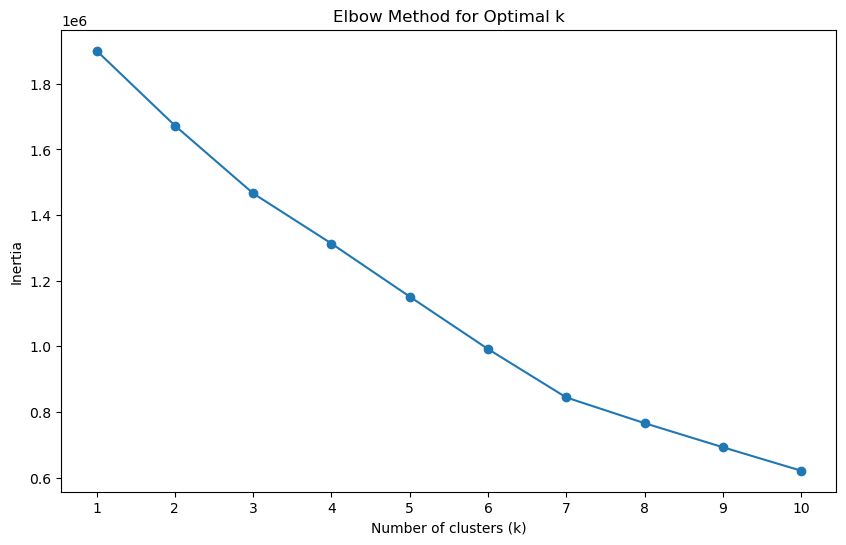


Cluster Analysis:


,Execution Price,Size Tokens,Size USD,Closed PnL,Fee,Trade Duration,PnL Percentage,Volatility,value
Cluster,,,,,,,,,
0,535.265267,5250.589241,2578.928891,43.923566,0.491507,16107.624926,0.023503,0.005767,52.049943
1,0.002594,5996.920000,15.560000,-5981.363990,0.005226,0.000000,-384.406426,0.000000,75.000000
2,87756.064030,222.052486,27112.467224,81.235765,5.882425,7807.412609,0.001809,0.001258,48.840058



Sentiment Distribution within Clusters:


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
Cluster,,,,,
0,0.105447,0.203127,0.278904,0.236009,0.176513
1,0.000000,1.000000,0.000000,0.000000,0.000000
2,0.072342,0.092572,0.390025,0.253236,0.191824


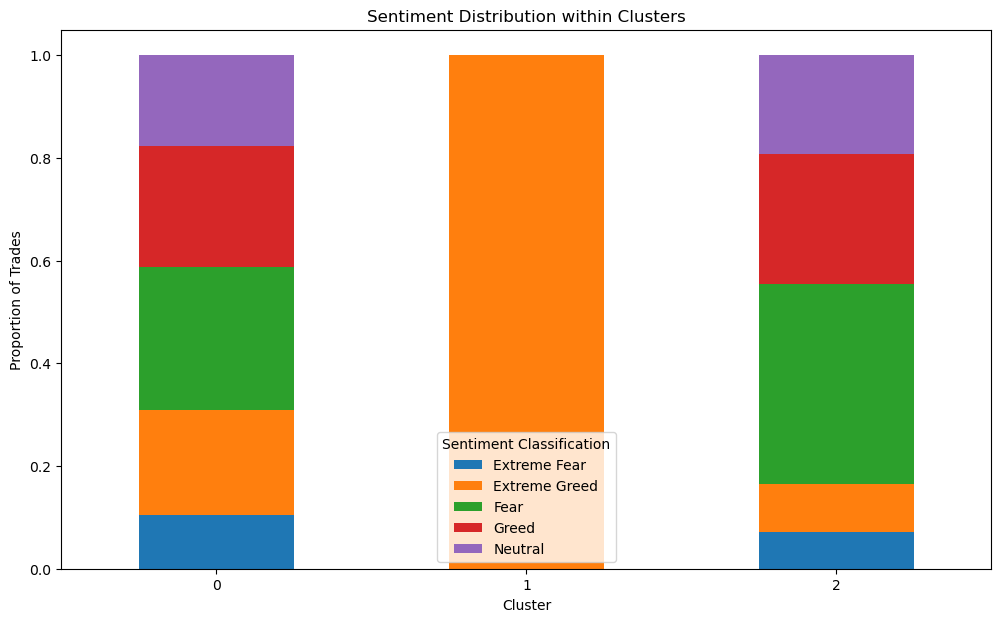

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Select relevant numerical features
features = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee', 'Trade Duration', 'PnL Percentage', 'Volatility', 'value']
X = merged_df[features].copy()

# Handle potential infinite values and NaNs before standardization and clustering
X.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X.dropna(inplace=True)

# Ensure the original merged_df also reflects the dropped rows if necessary for subsequent analysis
merged_df_cleaned = merged_df.loc[X.index].copy()


# 2. Standardize the selected numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply a clustering algorithm (K-Means) and determine the appropriate number of clusters
# Using the elbow method to find the optimal number of clusters
inertia = []
# Test k from 1 to 10
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

# Based on the elbow plot, choose an appropriate number of clusters (e.g., 3 or 4)
# Let's choose k=3 for demonstration
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Added n_init
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the cleaned dataframe
merged_df_cleaned['Cluster'] = clusters

# 4. Analyze the characteristics of each identified cluster
print("\nCluster Analysis:")
cluster_characteristics = merged_df_cleaned.groupby('Cluster')[features].mean()
display(cluster_characteristics)

# 5. Explore the distribution of sentiment classifications within each cluster
print("\nSentiment Distribution within Clusters:")
sentiment_cluster_distribution = merged_df_cleaned.groupby('Cluster')['classification'].value_counts(normalize=True).unstack().fillna(0)
display(sentiment_cluster_distribution)

# Visualize sentiment distribution within clusters
sentiment_cluster_distribution.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Sentiment Distribution within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Trades')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Classification')
plt.show()

## Insight generation

Summarize the key findings and insights regarding the relationship between trader performance and market sentiment.


**Reasoning**:

Synthesize the key findings from the previous steps and draft a concise summary highlighting the most significant relationships and patterns discovered, including actionable insights for trading strategies.



In [12]:
# Review of findings:
# 1. EDA: Weak linear correlation between sentiment value and performance metrics. Some differences in distribution of PnL across sentiment classifications, but with significant overlap.
# 2. Sentiment Analysis Integration: Higher *average* PnL in Extreme Greed and Fear. Longer *average* trade duration and higher *average* volatility in Extreme Greed and Greed. Median PnL and trade duration are zero across all sentiment classifications, indicating many small/short trades.
# 3. Pattern Recognition (Clustering):
#    - Cluster 0: Moderate trades, positive PnL, longer duration, diverse sentiment (slight lean to Fear/Greed).
#    - Cluster 1: Low execution price/USD size, negative PnL, zero duration, exclusively Extreme Greed. Likely represents specific type of trade or data anomaly.
#    - Cluster 2: High execution price/USD size, positive PnL, shorter duration, higher proportion in Fear sentiment.

print("Key Findings and Insights:")

print("\nRelationship between Sentiment and Trader Performance:")
print("- Overall, there is a weak linear correlation between the numerical sentiment value and individual trade performance metrics like PnL, trade duration, and volatility.")
print("- However, when examining sentiment by classification, differences in *average* performance are observed.")
print("  - Trades during 'Extreme Greed' and 'Fear' sentiment periods show higher average Closed PnL and PnL Percentage compared to other classifications.")
print("  - 'Extreme Greed' and 'Greed' periods are associated with longer average trade durations and higher average volatility.")
print("- It's important to note that median PnL and trade duration are zero across all sentiment classifications. This suggests that while some trades may be significantly impacted by sentiment, a large volume of trades, regardless of sentiment, result in minimal profit/loss and are of very short duration.")

print("\nPatterns Identified Through Clustering:")
print("- Three distinct trading behavior clusters were identified:")
print("  - Cluster 0: Represents typical, moderate-sized trades with overall positive performance, occurring across various sentiment states.")
print("  - Cluster 1: A unique cluster characterized by negative PnL and zero trade duration, exclusively appearing during 'Extreme Greed' sentiment. This warrants further investigation as it might represent specific trading strategies or data recording nuances under highly bullish conditions.")
print("  - Cluster 2: Involves high-value trades with positive PnL and shorter durations. This cluster has a higher proportion of trades occurring during 'Fear' sentiment, which is counter-intuitive and could suggest contrarian trading behavior or specific market dynamics during fear periods.")

print("\nActionable Insights for Trading Strategies:")
print("- **Consider Sentiment State:** While sentiment value alone isn't a strong predictor, the *classification* of sentiment appears to correlate with average trade outcomes. Traders might explore strategies that adjust based on sentiment state, potentially being more aggressive or cautious during certain periods.")
print("- **Extreme Greed Caution:** The association of Cluster 1 (negative PnL, zero duration) exclusively with 'Extreme Greed' suggests that this sentiment state might be associated with increased risk or specific market conditions that lead to unsuccessful trades for a segment of traders. Caution might be advisable during 'Extreme Greed'.")
print("- **Fear as Opportunity (for some):** The prevalence of high-value, positive PnL trades (Cluster 2) during 'Fear' sentiment could indicate opportunities for contrarian strategies, buying during market dips driven by fear.")
print("- **Focus on Trade Execution:** The high frequency of trades with zero median PnL and duration across all sentiments highlights the importance of trade execution and minimizing costs (like fees) for overall profitability, regardless of broader market sentiment.")
print("- **Further Investigation of Cluster 1:** Understanding the specific nature of trades in Cluster 1 during 'Extreme Greed' is crucial. Is it related to specific assets, trading bots, or high-frequency trading strategies that behave differently in this sentiment state? This could lead to more targeted strategic adjustments.")


Key Findings and Insights:

Relationship between Sentiment and Trader Performance:
- Overall, there is a weak linear correlation between the numerical sentiment value and individual trade performance metrics like PnL, trade duration, and volatility.
- However, when examining sentiment by classification, differences in *average* performance are observed.
  - Trades during 'Extreme Greed' and 'Fear' sentiment periods show higher average Closed PnL and PnL Percentage compared to other classifications.
  - 'Extreme Greed' and 'Greed' periods are associated with longer average trade durations and higher average volatility.
- It's important to note that median PnL and trade duration are zero across all sentiment classifications. This suggests that while some trades may be significantly impacted by sentiment, a large volume of trades, regardless of sentiment, result in minimal profit/loss and are of very short duration.

Patterns Identified Through Clustering:
- Three distinct trading behavio

Present the findings in a clear and concise manner, including visualizations and interpretations.


**Reasoning**:

Create visualizations to illustrate the key findings from the analysis, including bar plots for average performance metrics by sentiment, a stacked bar chart for sentiment distribution within clusters, and scatter plots for key variables and sentiment. Provide a brief interpretation for each visualization.



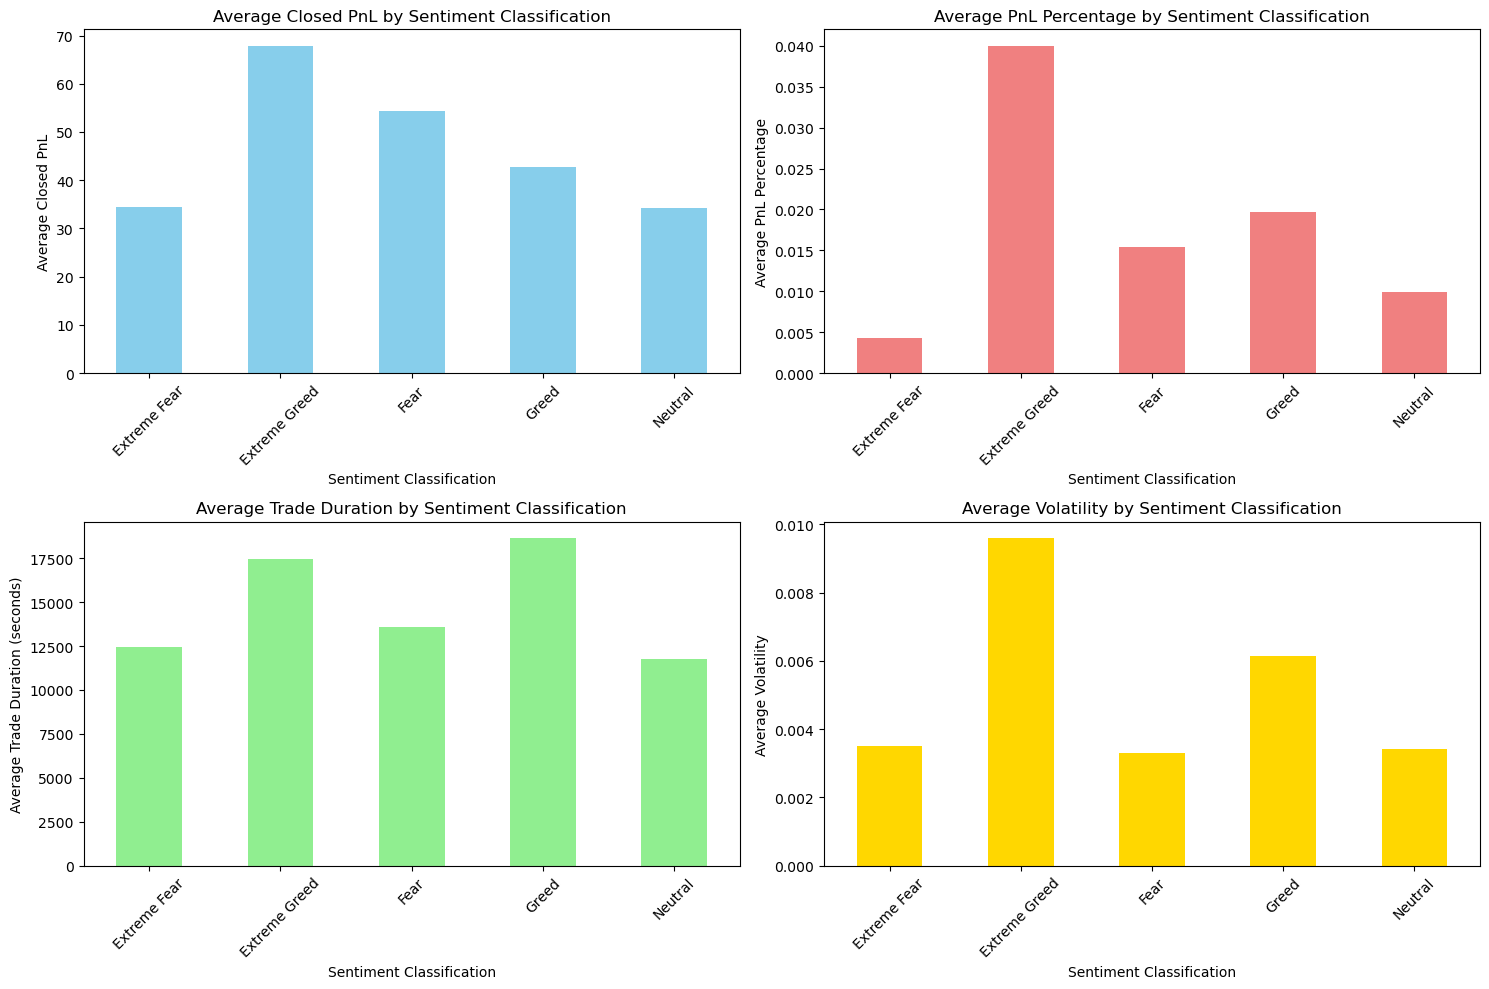

Interpretation of Average Performance by Sentiment Plots:
These bar plots show the average Closed PnL, PnL Percentage, Trade Duration, and Volatility for each sentiment classification. We can observe how different market sentiment states correlate with average trading outcomes and behaviors. For instance, 'Extreme Greed' and 'Fear' tend to show higher average PnL, while 'Extreme Greed' and 'Greed' are associated with longer average trade durations and higher volatility.


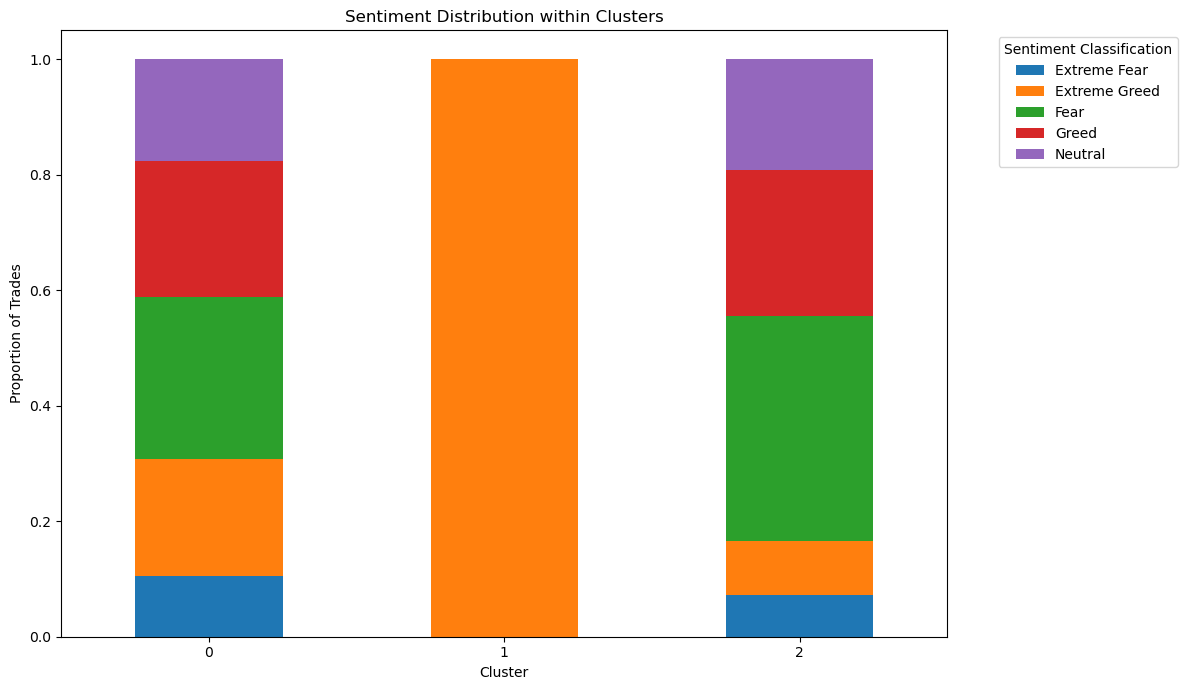


Interpretation of Sentiment Distribution within Clusters Plot:
This stacked bar chart illustrates the proportion of trades falling into each sentiment classification within the three identified trading clusters. It helps visualize how different trading behaviors (represented by the clusters) are distributed across market sentiment states. For example, Cluster 1 is exclusively in 'Extreme Greed', while Cluster 2 has a larger proportion in 'Fear'.


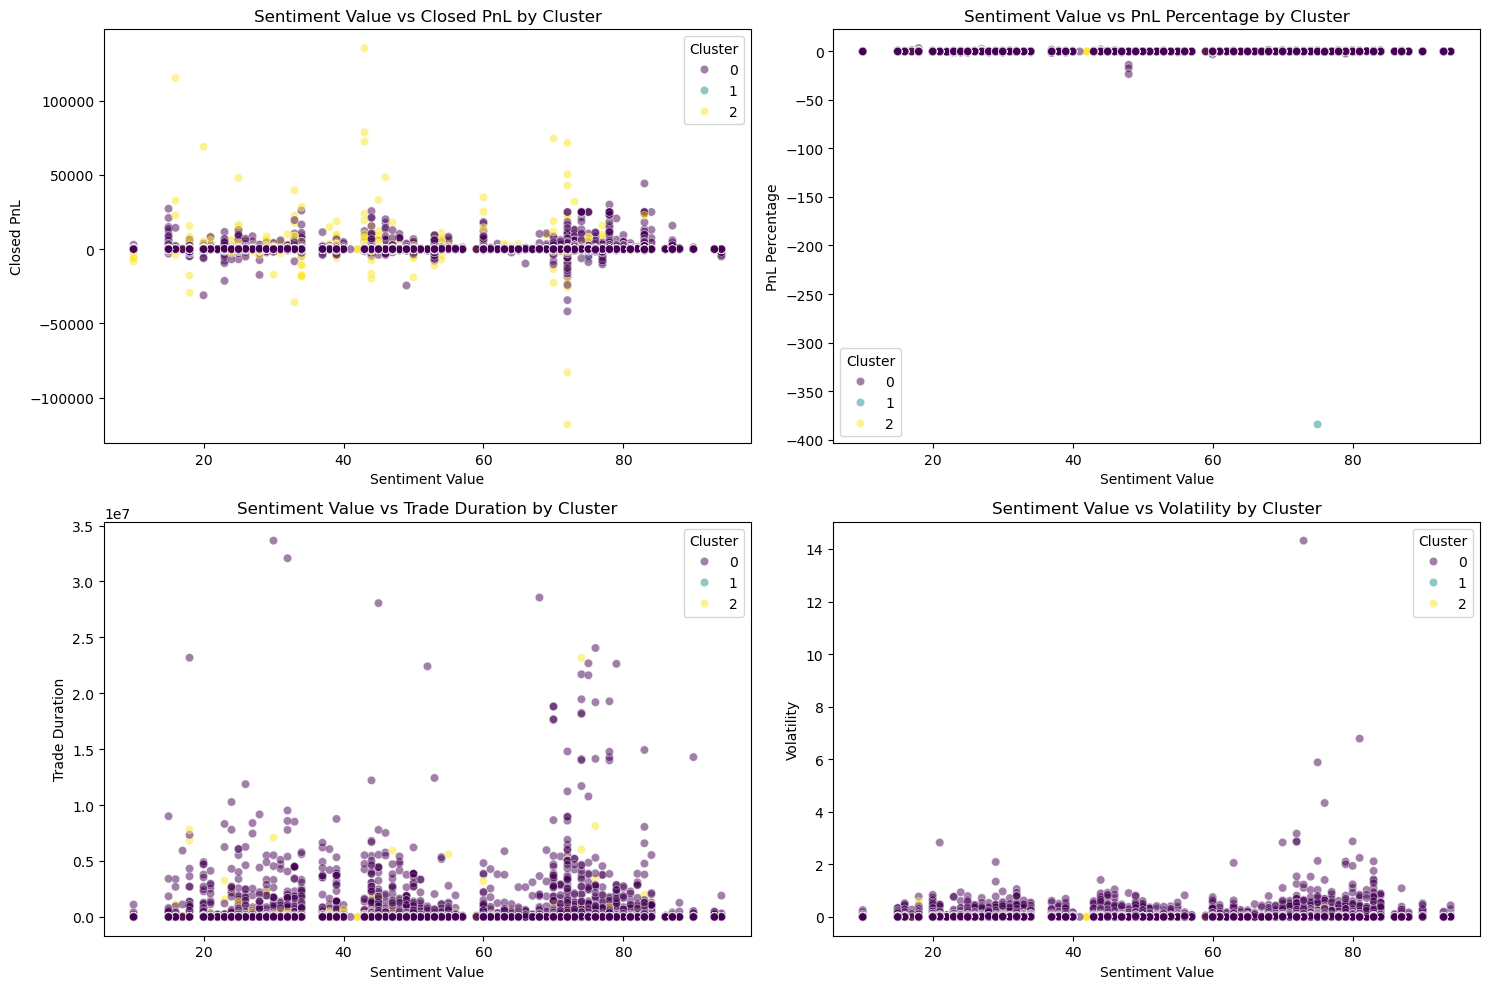


Interpretation of Scatter Plots (Sentiment vs. Performance by Cluster):
These scatter plots show the relationship between the numerical sentiment value and key performance metrics, with points colored by their assigned cluster. While overall linear correlation is weak, coloring by cluster helps to see if specific clusters exhibit different patterns or distributions across the sentiment value range. This reinforces the idea that distinct trading behaviors within clusters might react differently to varying sentiment levels.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar plots showing average performance metrics by sentiment classification.
# Using the previously calculated sentiment_performance DataFrame

sentiment_performance_avg = sentiment_performance[['Avg_Closed_PnL', 'Avg_PnL_Percentage', 'Avg_Trade_Duration', 'Avg_Volatility']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

sentiment_performance_avg['Avg_Closed_PnL'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Average Closed PnL by Sentiment Classification')
axes[0].set_xlabel('Sentiment Classification')
axes[0].set_ylabel('Average Closed PnL')
axes[0].tick_params(axis='x', rotation=45)

sentiment_performance_avg['Avg_PnL_Percentage'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Average PnL Percentage by Sentiment Classification')
axes[1].set_xlabel('Sentiment Classification')
axes[1].set_ylabel('Average PnL Percentage')
axes[1].tick_params(axis='x', rotation=45)

sentiment_performance_avg['Avg_Trade_Duration'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Average Trade Duration by Sentiment Classification')
axes[2].set_xlabel('Sentiment Classification')
axes[2].set_ylabel('Average Trade Duration (seconds)')
axes[2].tick_params(axis='x', rotation=45)

sentiment_performance_avg['Avg_Volatility'].plot(kind='bar', ax=axes[3], color='gold')
axes[3].set_title('Average Volatility by Sentiment Classification')
axes[3].set_xlabel('Sentiment Classification')
axes[3].set_ylabel('Average Volatility')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Interpretation of Average Performance by Sentiment Plots:")
print("These bar plots show the average Closed PnL, PnL Percentage, Trade Duration, and Volatility for each sentiment classification. We can observe how different market sentiment states correlate with average trading outcomes and behaviors. For instance, 'Extreme Greed' and 'Fear' tend to show higher average PnL, while 'Extreme Greed' and 'Greed' are associated with longer average trade durations and higher volatility.")


# 2. Visualization of the sentiment distribution within each identified cluster (stacked bar chart).
# Using the previously calculated sentiment_cluster_distribution DataFrame

sentiment_cluster_distribution.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Sentiment Distribution within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Trades')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nInterpretation of Sentiment Distribution within Clusters Plot:")
print("This stacked bar chart illustrates the proportion of trades falling into each sentiment classification within the three identified trading clusters. It helps visualize how different trading behaviors (represented by the clusters) are distributed across market sentiment states. For example, Cluster 1 is exclusively in 'Extreme Greed', while Cluster 2 has a larger proportion in 'Fear'.")


# 3. Scatter plots to show relationships between key variables and sentiment (revisiting from EDA for presentation).
# Using the cleaned data with clusters

performance_metrics = ['Closed PnL', 'PnL Percentage', 'Trade Duration', 'Volatility']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(performance_metrics):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=merged_df_cleaned, x='value', y=metric, alpha=0.5, hue='Cluster', palette='viridis', legend='full')
    plt.title(f'Sentiment Value vs {metric} by Cluster')
    plt.xlabel('Sentiment Value')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

print("\nInterpretation of Scatter Plots (Sentiment vs. Performance by Cluster):")
print("These scatter plots show the relationship between the numerical sentiment value and key performance metrics, with points colored by their assigned cluster. While overall linear correlation is weak, coloring by cluster helps to see if specific clusters exhibit different patterns or distributions across the sentiment value range. This reinforces the idea that distinct trading behaviors within clusters might react differently to varying sentiment levels.")